In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline

from scipy.stats.stats import pearsonr
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


#from sklearn.feature_selection import SelectFromModel #RFE 

#from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

from time import time

# supress some warnings that mess up my slides
import warnings; warnings.simplefilter('ignore')

# Data driven prediction models of energy use of appliances in alow-energy house

# COMP6200 Portfolio 2

The goal of the second portfolio is to reproduce some work on predicting the energy usage of a house based on Internet of Things (IoT) measurements of temperature and humidity and weather observations.

__Introduction:__ the electricity consumption in domestic buildings is explained by two main factors: the type and number of electrical appliances and the use of the appliances by the occupants. Naturally, both factors are interrelated. The domestic appliances use by the occupants would leave traceable signals in the indoor environment near the vicinity of the appliance, for example: the temperature, humidity, vibrations, light and noise. The occupancy level of the building in different locations could also help to determine the use of the appliances. In this work, the prediction was carried out using different data sources and environmental parameters (indoor and outdoor conditions). Specifically, data from a nearby airport weather station, temperature and humidity in different rooms in the house from a wireless sensor network and one sub-metered electrical energy consumption (lights) have been used to predict the energy use by appliances.

This work explores several questions. Is the weather data obtained from a nearby weather station representative enough to improve the appliances energy consumption prediction? Can the temperature and humidity measurements from a wireless network help in the energy prediction? From all the data used in prediction models, which parameters are the most important in energy prediction?

In [2]:
test = pd.read_csv('data/testing.csv', index_col='date', parse_dates=True)
#testing.head() #4932 rows × 31 columnss

In [3]:
train = pd.read_csv('data/training.csv', index_col='date', parse_dates=True)
#training.head()#14803 rows × 31 columns

In [4]:
#combine testing and training to new dataframe 'data'
data = pd.concat([train, test] , axis=0)
data.head()
#data.shape #19735 rows× 31 columnss

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,45.730000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


__Dataset and Exploratory Analysis:__ 

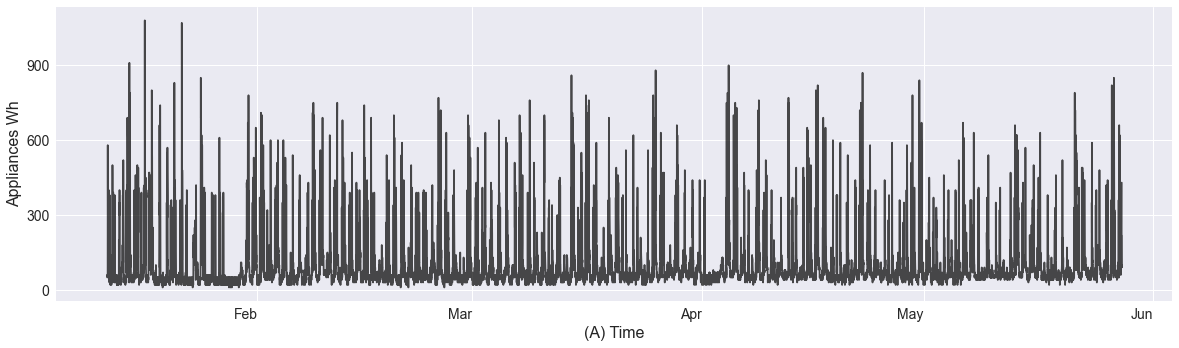

In [5]:
#set locator and date format %b - Jan, Feb, Mar...
locator = mdates.MonthLocator() 
fmt = mdates.DateFormatter('%b') 

data.Appliances.plot(figsize=(20,6), c='black', alpha = 0.7, grid=True, markersize=0.5)
plt.xlabel('(A) Time', fontsize = 16)
plt.ylabel('Appliances Wh', fontsize = 16)
plt.xticks(rotation=0, fontsize= 14) 
plt.yticks(np.arange(0, 1200, 300), fontsize= 14)

ax = plt.gca().xaxis
ax.set_major_locator(locator)
ax.set_major_formatter(fmt)

plt.show()

Fig 1. (A) Appliances energy consumption measurement for the whole period.

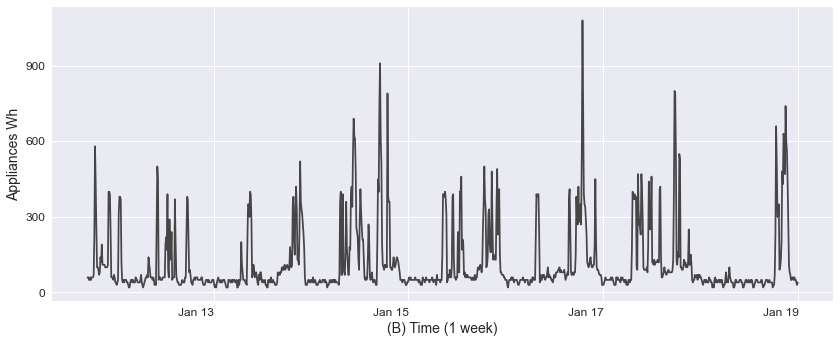

In [6]:
#set locator and date format
locator = mdates.DayLocator() 
fmt = mdates.DateFormatter('%b %d') 

start, end = '2016-1-11', '2016-1-18'
data.Appliances.loc[start:end].plot(figsize=(14,6), c='black', alpha = 0.7, grid=True)
plt.xlabel('(B) Time (1 week)', fontsize = 14)
plt.ylabel('Appliances Wh', fontsize = 14)
plt.xticks(rotation=0, fontsize= 12) 
plt.yticks(np.arange(0, 1200, 300) , fontsize= 12)


ax = plt.gca().xaxis
ax.set_major_locator(locator)
ax.set_major_formatter(fmt)
#ax.set_major_locator(ticker.LinearLocator(5))
ax.set_major_locator(mdates.DayLocator(bymonthday=(13, 15, 17, 19)))

plt.show()

Fig 1. (B) A closer look at the first week of data.

__Appliances energy consumption distribution__

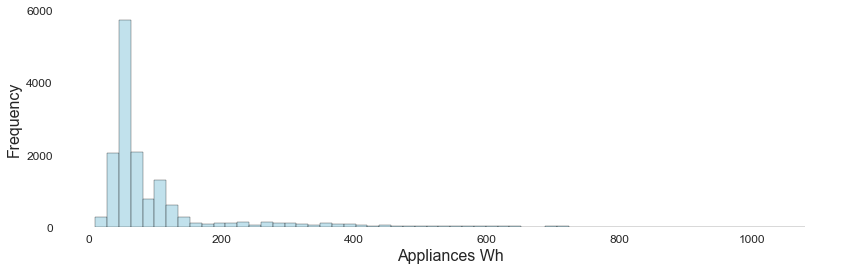

In [7]:
plt.figure(figsize=(14,4))
sns.histplot(data=train, x='Appliances', bins=60, color='lightblue').set_facecolor('xkcd:white')
plt.xlabel('Appliances Wh', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize= 12) 
plt.yticks(np.arange(0, 8000, 2000), fontsize= 12)

plt.show()

Fig. 2. (A) The histogram shows the frequency of energy consumption in the interval (bar width)

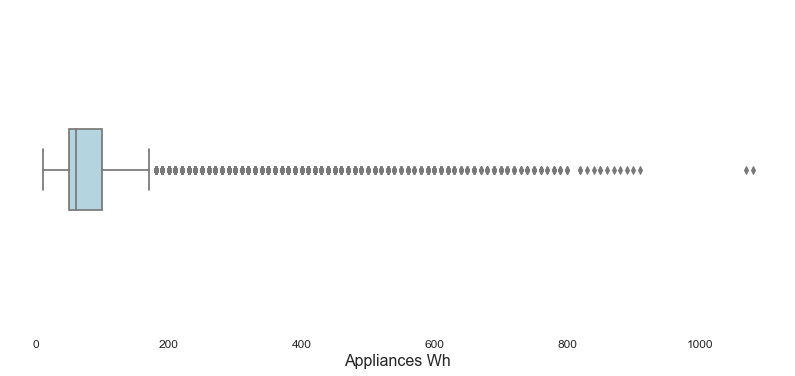

In [8]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Appliances', data=data, width=0.25, color='lightblue').set_facecolor('xkcd:white')
plt.xlabel('Appliances Wh', fontsize = 16)
plt.xticks(fontsize= 12) 
plt.yticks(fontsize= 12)
plt.show()

Fig. 2. (B)  The boxplot shows the location of the median with the black line.

__PairGrid__

In [9]:
cols1 = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3']
cols2 = ['Appliances', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6']
cols3 = ['Appliances', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9']
cols4 = ['Appliances', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'NSM', 'T6']

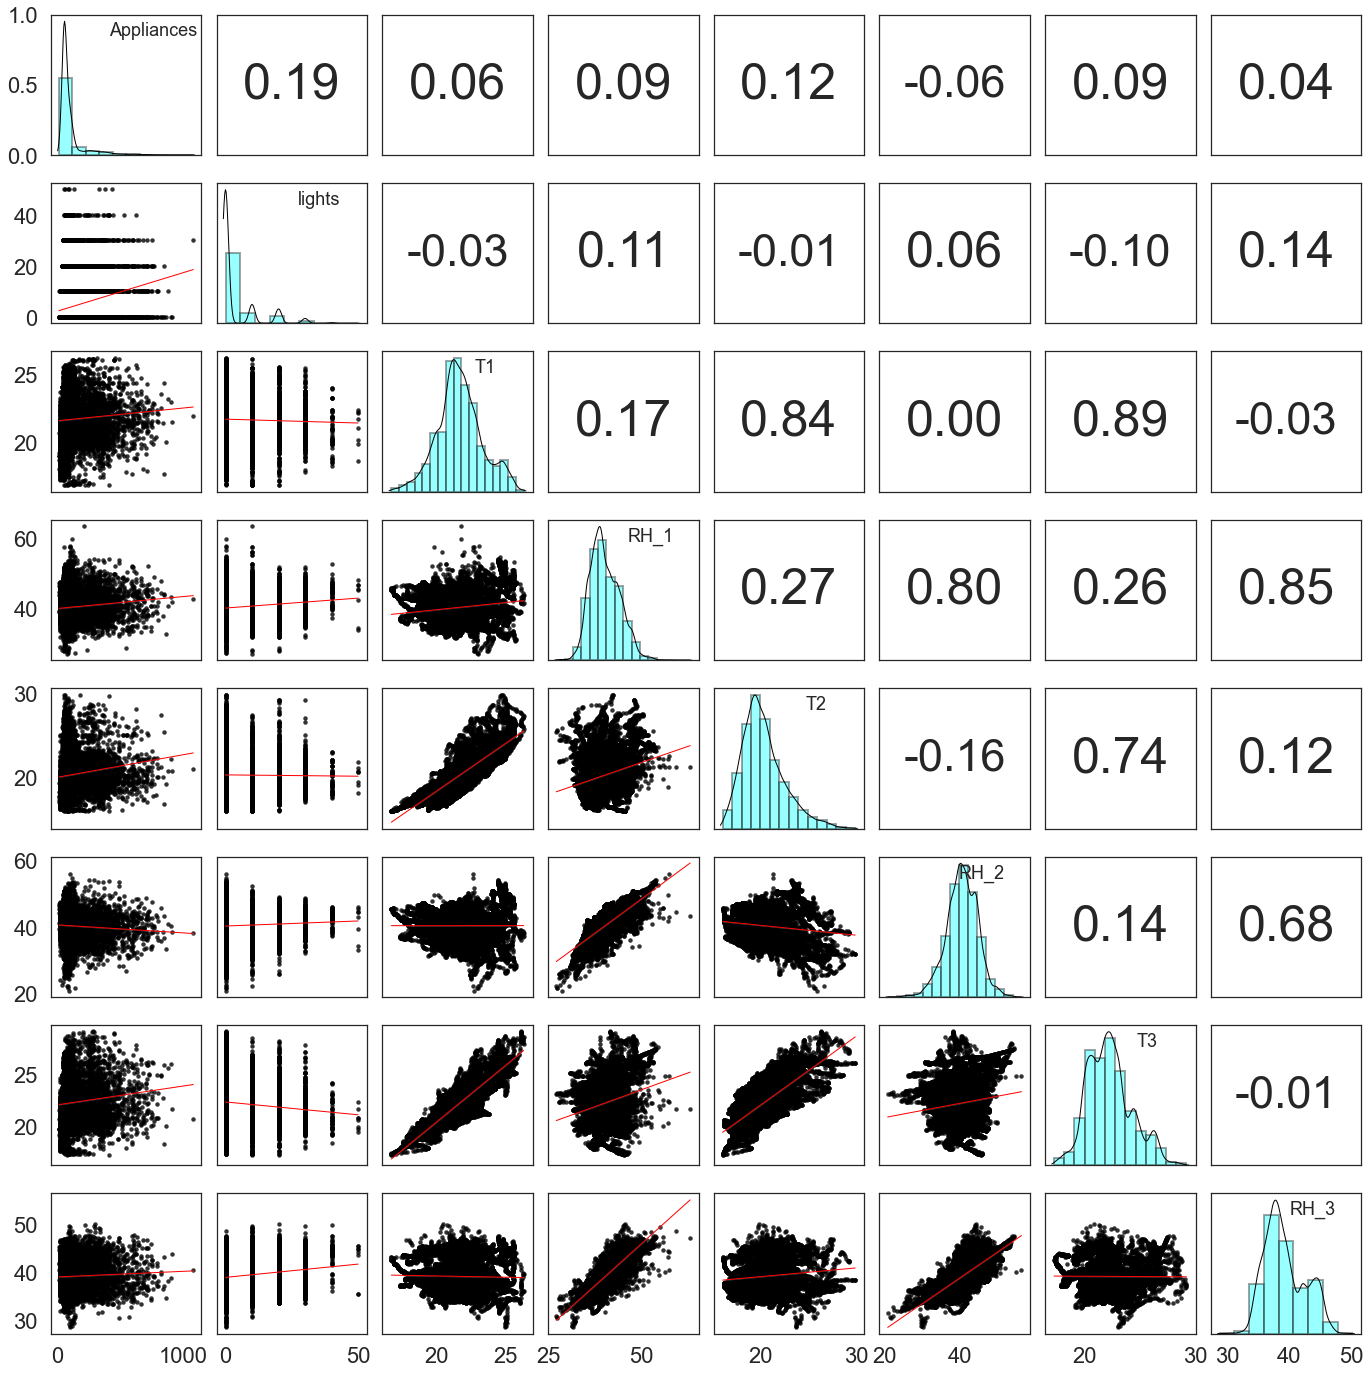

In [10]:
cols = iter(cols1)
#Upper    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}"
    ax = plt.gca()
    #set corr font size
    if corr_r < 0.0:
        font_size = 45
    if corr_r >= 0.0:
        font_size = 50
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    

#Diagonal
#Put variable names on diagonal of Seaborn PairGrid
def diagfunc(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.68, 0.85), xycoords=ax.transAxes, fontsize = 18, ha="center")

#adjust no. of bins of each subplot on the diagonal
nbins = iter([10,9,17,16,14,15,13,9])
def myhist(*args, **kwargs):
    sns.distplot(*args, bins=next(nbins), **kwargs)

#PairGrid
sns.set(style='white', font_scale=2)
g = sns.PairGrid(train, vars=cols1, aspect=1.0, diag_sharey=False, despine=False, height=2.5).map_diag(diagfunc)


g.map_upper(corrdot)
g.map_diag(myhist,
          hist_kws = {'histtype': 'bar', 'edgecolor': 'k', 'lw': 2,  'facecolor':'aqua'}, 
          kde_kws = {'color': 'black', 'lw': 1, 'cut': 0.7}) 
g.map_lower(sns.regplot, ci=False,
            line_kws = {'color': 'red', 'lw': 1},
            scatter_kws = {'color': 'black', 's': 20})


g.fig.subplots_adjust(wspace=0.1, hspace=0.2)

#Remove the normal axis titles
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.show()

Fig. 3. (A) Pairs plot. Relationship between the energy consumption of appliances with: lights, T1, RH1, T2, RH2, T3, RH3. T1 and RH1 correspond to the kitchen conditions; T2and RH2 correspond to the living room conditions.

Fig. 3. (A) shows that there is a positive correlation between the energy consumption of appliances and lights (0.19). The second largest correlation is between appliances and T2. For the indoor temperatures, the correlations are high as expected, since the ventilation is driven by the HRV unit and minimizes air temperature differences between rooms. For example, a positive correlation is found with T1 and T3.

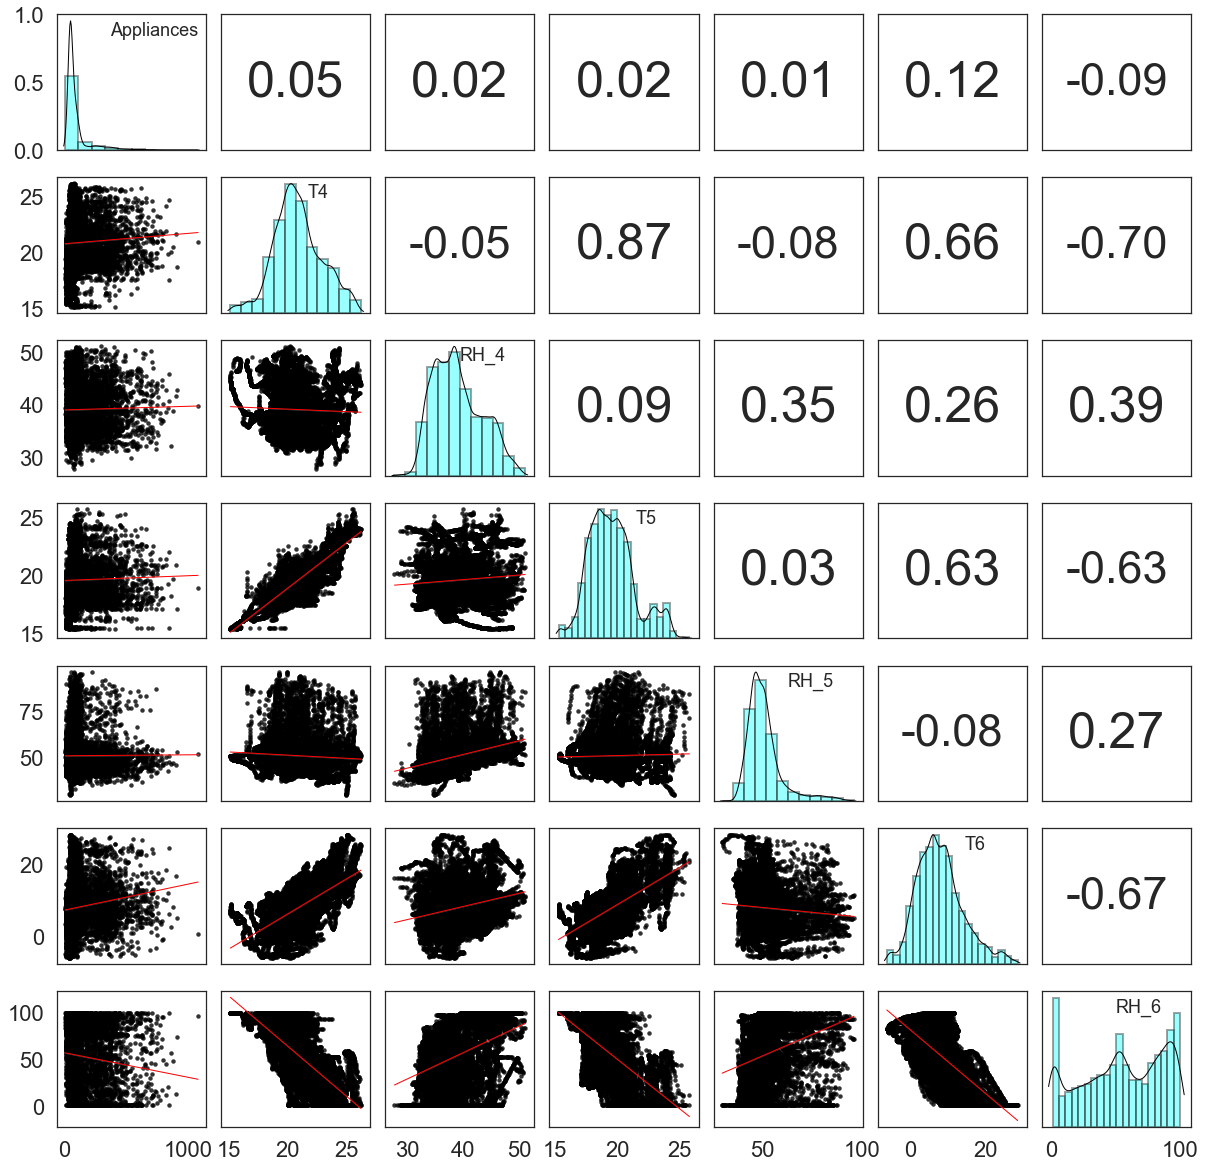

In [11]:
cols = iter(cols2)
#Upper    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}"
    ax = plt.gca()
    #set corr font size
    if corr_r < 0.0:
        font_size = 45
    if corr_r >= 0.0:
        font_size = 50
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    

#Diagonal
#Put variable names on diagonal of Seaborn PairGrid
def diagfunc(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.65, 0.85), xycoords=ax.transAxes, fontsize = 18, ha="center")

#adjust no. of bins of each subplot on the diagonal
nbins = iter([10,12,12,20,12,20,20])
def myhist(*args, **kwargs):
    sns.distplot(*args, bins=next(nbins), **kwargs)

#PairGrid
sns.set(style='white', font_scale=2)
g = sns.PairGrid(train, vars=cols2, aspect=1.0, diag_sharey=False, despine=False, height=2.5).map_diag(diagfunc)

g.map_upper(corrdot)
g.map_diag(myhist,
          hist_kws = {'histtype': 'bar', 'edgecolor': 'k', 'lw': 2,  'facecolor':'aqua'}, 
          kde_kws = {'color': 'black', 'lw': 1, 'cut': 0.7}) 
g.map_lower(sns.regplot, ci=False,
            line_kws = {'color': 'red', 'lw': 1},
            scatter_kws = {'color': 'black', 's': 20})


g.fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.2)
#g.fig.suptitle('ONE TITLE FOR ALL', fontsize=16)

#Remove the normal axis titles
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.show()

Fig. 3. (B) Pairs plot. Relationship between the energy consumption of appliances with: lights, T1, RH1, T2, RH2, T3, RH3. T1 and RH1 correspond to the kitchen conditions; T2and RH2 correspond to the living room conditions.

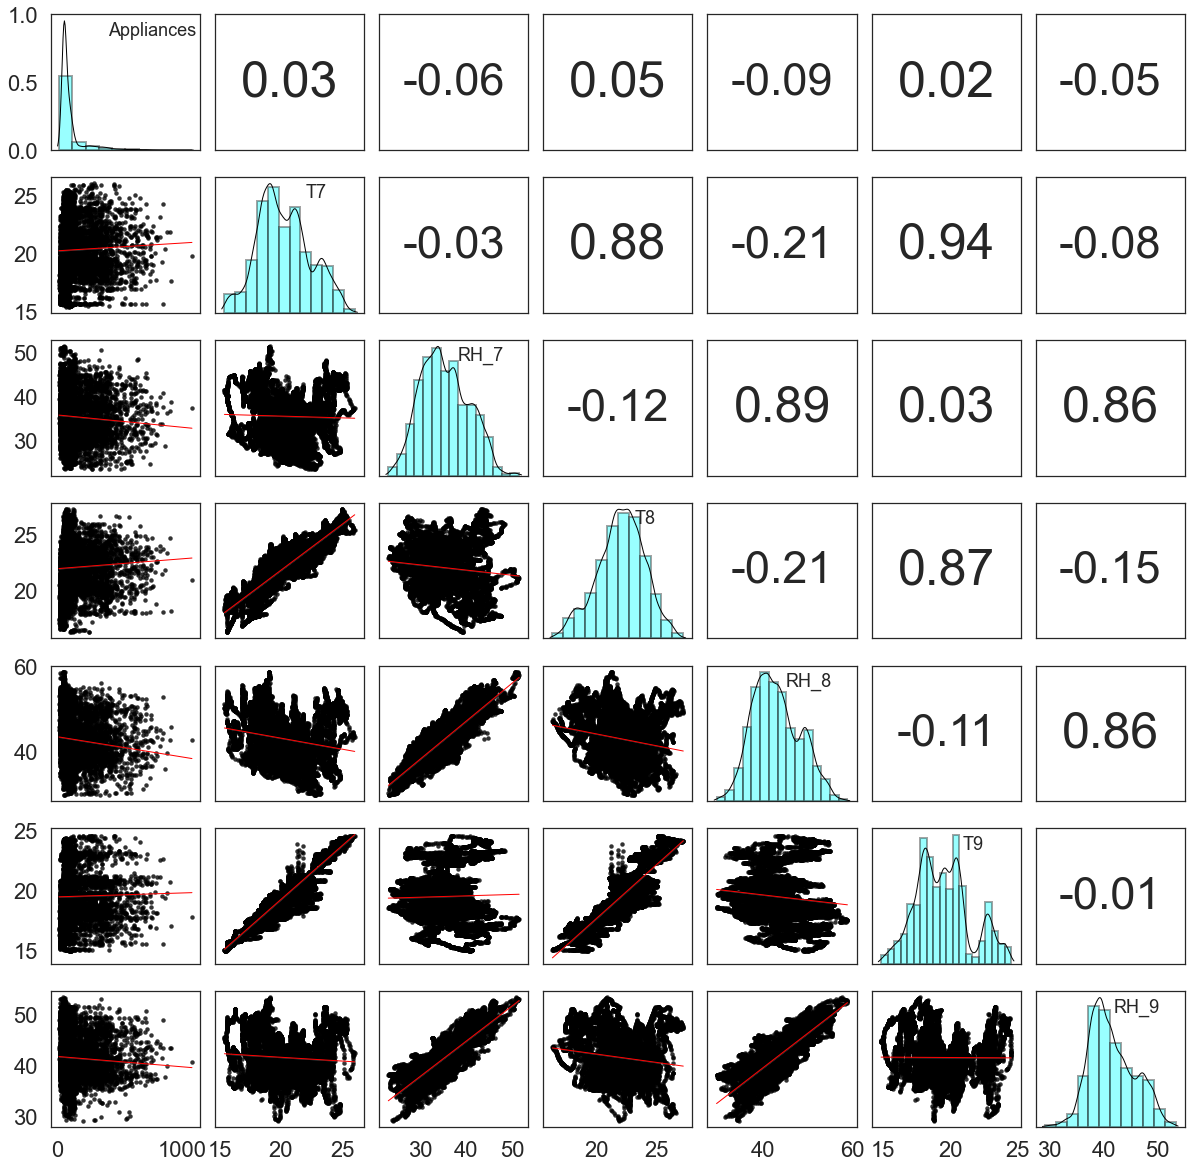

In [12]:
cols = iter(cols3)
#Upper    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}"
    ax = plt.gca()
    #set corr font size
    if corr_r < 0.0:
        font_size = 45
    if corr_r >= 0.0:
        font_size = 50
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    

#Diagonal
#Put variable names on diagonal of Seaborn PairGrid
def diagfunc(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.68, 0.85), xycoords=ax.transAxes, fontsize = 18, ha="center")

#adjust no. of bins of each subplot on the diagonal
nbins = iter([10,12,15,12,15,20,12])
def myhist(*args, **kwargs):
    sns.distplot(*args, bins=next(nbins), **kwargs)

#PairGrid
sns.set(style='white', font_scale=2)
g = sns.PairGrid(train, vars=cols3, aspect=1.0, diag_sharey=False, despine=False, height=2.5).map_diag(diagfunc)

g.map_upper(corrdot)
g.map_diag(myhist,
          hist_kws = {'histtype': 'bar', 'edgecolor': 'k', 'lw': 2,  'facecolor':'aqua'}, 
          kde_kws = {'color': 'black', 'lw': 1, 'cut': 0.7}) 
g.map_lower(sns.regplot, ci=False,
            line_kws = {'color': 'red', 'lw': 1},
            scatter_kws = {'color': 'black', 's': 20})


g.fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.2)
#g.fig.suptitle('ONE TITLE FOR ALL', fontsize=16)

#Remove the normal axis titles
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.show()

Fig. 3. (C) Pairs plot. Relationship between the energy consumption of appliances with: lights, T1, RH1, T2, RH2, T3, RH3. T1 and RH1 correspond to the kitchen conditions; T2and RH2 correspond to the living room conditions.

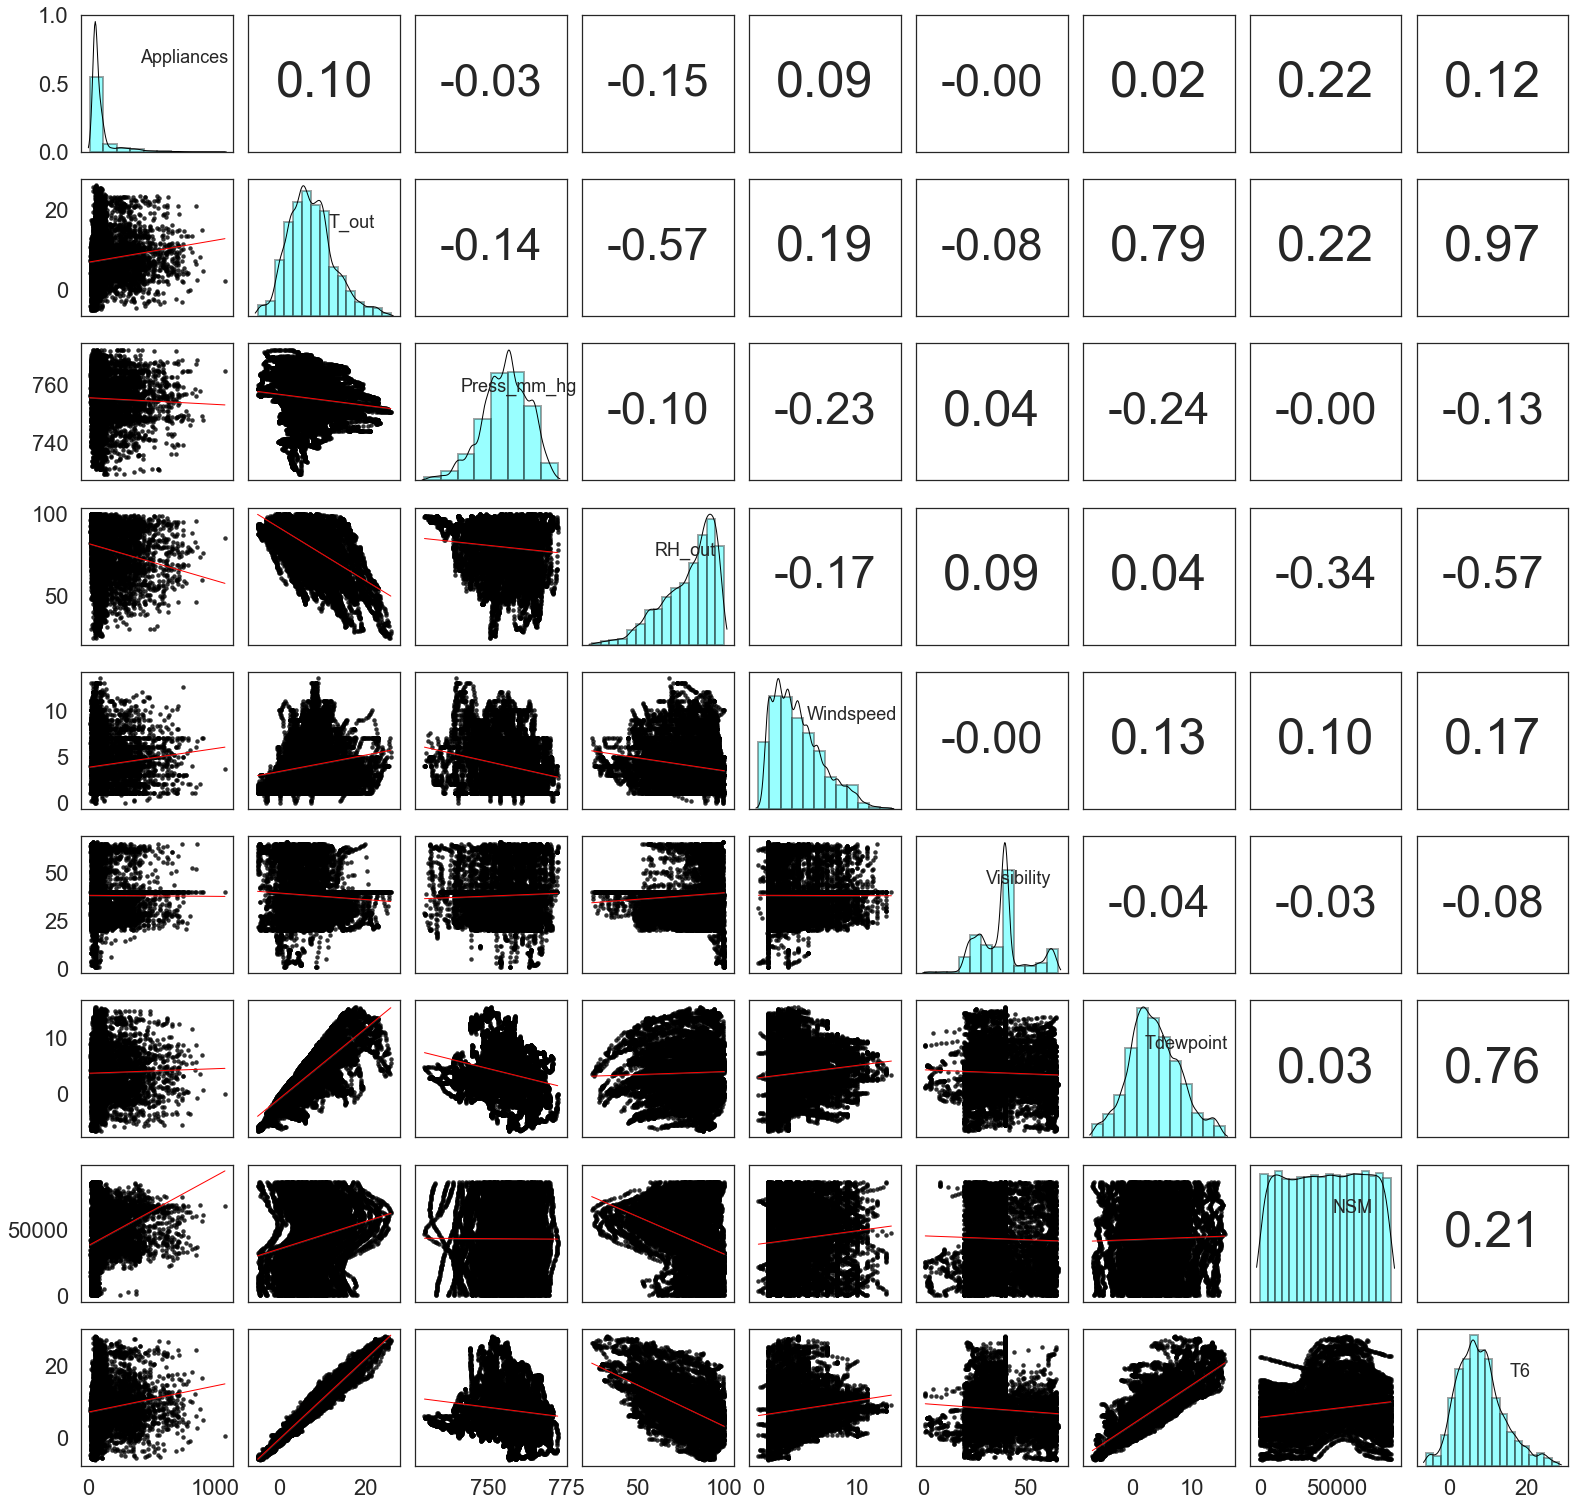

In [13]:
cols = iter(cols4)
#Upper    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}"
    ax = plt.gca()
    #set corr font size
    if corr_r < 0.0:
        font_size = 45
    if corr_r >= 0.0:
        font_size = 50
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    

#Diagonal
#Put variable names on diagonal of Seaborn PairGrid
def diagfunc(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.68, 0.65), xycoords=ax.transAxes, fontsize = 18, ha="center")

#adjust no. of bins of each subplot on the diagonal
nbins = iter([10,15,8,15,12,12,12,18,18])
def myhist(*args, **kwargs):
    sns.distplot(*args, bins=next(nbins), **kwargs)

#PairGrid
sns.set(style='white', font_scale=2)
g = sns.PairGrid(train, vars=cols4, aspect=1.0, diag_sharey=False, despine=False, height=2.5).map_diag(diagfunc)

g.map_upper(corrdot)
g.map_diag(myhist,
          hist_kws = {'histtype': 'bar', 'edgecolor': 'k', 'lw': 2,  'facecolor':'aqua'}, 
          kde_kws = {'color': 'black', 'lw': 1, 'cut': 0.7}) 
g.map_lower(sns.regplot, ci=False,
            line_kws = {'color': 'red', 'lw': 1},
            scatter_kws = {'color': 'black', 's': 20})


g.fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.2)
#g.fig.suptitle('ONE TITLE FOR ALL', fontsize=16)

#Remove the normal axis titles
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.show()

Fig. 3. (D) Pairs plot. Relationship between the energy consumption of appliances with: lights, T1, RH1, T2, RH2, T3, RH3. T1 and RH1 correspond to the kitchen conditions; T2and RH2 correspond to the living room conditions.

__Heatmap__

In [14]:
#get Hour from strftime
data['Hour_of_day'] = data.index.strftime("%H") 
data['Hour_of_day'] = data['Hour_of_day'].astype(int) #convert from datetime object to int
#create Date from strftime
data['Date'] = data.index.strftime("%Y-%m-%d") 
#data.dtypes

In [15]:
#create new df 'Hourly_data' 
cols = ['Date', 'Hour_of_day', 'Day_of_week', 'Appliances']
Hourly_data = data[cols]
#Hourly_data #19735

In [16]:
#create column 'Days' to store the short name of Day_of_week
days = {'Monday':'Mon', 'Tuesday':'Tues', 'Wednesday':'Weds', 'Thursday':'Thurs', 'Friday':'Fri', 'Saturday':'Sat','Sunday':'Sun'}
Hourly_data['Days'] = Hourly_data['Day_of_week'].apply(lambda x: days[x])
#re-order Days column
Hourly_data['Days'] = pd.Categorical(Hourly_data['Days'], categories=['Sun', 'Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat'], ordered=True)

#drop Day_of_week column
drop_cols = ['Day_of_week'] #drop Appliances column
Hourly_data.drop(drop_cols, axis=1, inplace=True)
#Hourly_data

In [17]:
#Calculate the maximum of Appliances
max_value = Hourly_data.groupby(['Date','Hour_of_day'])['Appliances'].transform('sum').max() #max_value #3650
min_value = Hourly_data.groupby(['Date','Hour_of_day'])['Appliances'].transform('sum').min()
print('Max appliances: ' , max_value , 'and min appliances: ', min_value)

Max appliances:  3650 and min appliances:  170


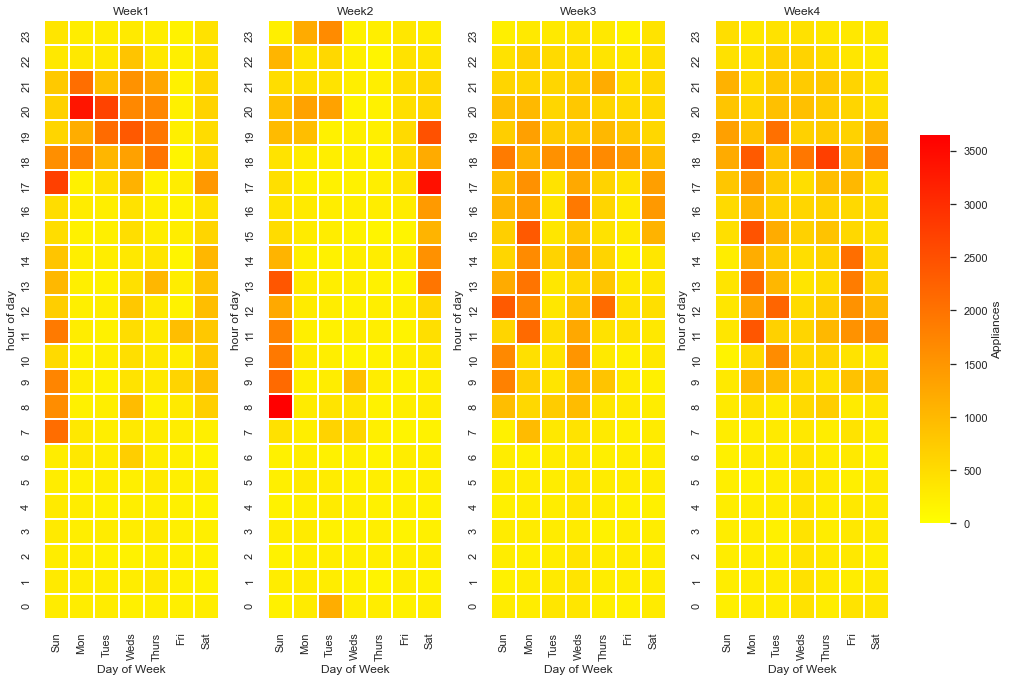

In [18]:
Week1 = Hourly_data.loc['2016-01-17':'2016-01-23']
Week2 = Hourly_data.loc['2016-01-24':'2016-01-30']
Week3 = Hourly_data.loc['2016-01-31':'2016-02-06']
Week4 = Hourly_data.loc['2016-02-07':'2016-02-13']

#reshape the data in long form to wide form using Pandas’s pivot_table() function.
heatmap_data1 = pd.pivot_table(Week1, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')
heatmap_data2 = pd.pivot_table(Week2, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')
heatmap_data3 = pd.pivot_table(Week3, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')
heatmap_data4 = pd.pivot_table(Week4, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')

#create list 'Hours' to store the reverse sorted of Hour_of_day
Hours=Hourly_data.Hour_of_day.unique().tolist()
Hours=sorted(Hours, reverse=True)

heatmap_data1=heatmap_data1.loc[Hours]
heatmap_data2=heatmap_data2.loc[Hours]
heatmap_data3=heatmap_data3.loc[Hours]
heatmap_data4=heatmap_data4.loc[Hours]

sns.set(style='white', font_scale=1)
fig, ax = plt.subplots(1, 4, figsize = (14, 18))
cbar_ax = fig.add_axes([.91, .35, .03, .3])
fig.tight_layout(rect=[0, 0, .9, 1])


g1 = sns.heatmap(heatmap_data1, ax=ax[0], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value, 
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='hour of day',
                                                                                   title = 'Week1')

g2 = sns.heatmap(heatmap_data2, ax=ax[1], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value, 
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='hour of day',
                                                                                    title = 'Week2')

g3 = sns.heatmap(heatmap_data3, ax=ax[2], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value, 
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='hour of day',
                                                                                   title = 'Week3')

g4 = sns.heatmap(heatmap_data4, ax=ax[3], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value,  
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='hour of day',
                                                                                   title = 'Week4')


plt.show()

Fig. 4. Hourly energy consumption of appliances heat map for four consecutive weeks.

An hourly heat map was created for four consecutive weeks ofdata to identify any time trends (see Fig. 4). As can be clearly seen, there is a strong time component in theenergy consumption pattern. The energy consumption starts to risearound 6 in the morning. Then around noon, there are energy loadsurges. The energy demand also increases around 6 pm. There is noclear pattern regarding the day of the week.

#### Performance of Regression Models:


The combined data set is split in training and test validation using CARET’S create data partition function. 75% of the data is used for the training of the models and the rest is used for testing.

In [19]:
train.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,45.730000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


In [20]:
test.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.79,45.000000,18.89,45.723333,...,733.800000,92.000000,6.000000,51.5,5.000000,45.410389,45.410389,63000,Weekday,Monday
2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.500000,19.79,44.900000,18.89,45.790000,...,734.100000,92.000000,5.000000,40.0,4.700000,47.233763,47.233763,64800,Weekday,Monday
2016-01-11 18:40:00,230,70,19.926667,45.863333,19.356667,44.400000,19.79,44.900000,18.89,46.430000,...,734.366667,91.333333,5.666667,40.0,4.633333,10.298729,10.298729,67200,Weekday,Monday
2016-01-11 18:50:00,580,60,20.066667,46.396667,19.426667,44.400000,19.79,44.826667,19.00,46.430000,...,734.433333,91.166667,5.833333,40.0,4.616667,8.827838,8.827838,67800,Weekday,Monday
2016-01-11 19:30:00,100,10,20.566667,53.893333,20.033333,46.756667,20.10,48.466667,19.00,48.490000,...,734.850000,89.500000,6.000000,40.0,4.350000,24.884962,24.884962,70200,Weekday,Monday


In [21]:
#train.dtypes

In [22]:
#test.dtypes

__Model__

In [23]:
cols = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 
        'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 
        'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 
        'RH_out', 'Windspeed', 'Tdewpoint', 'NSM', 'WeekStatus', 'Day_of_week']

In [24]:
X_train = train[cols]
X_train = pd.get_dummies(X_train, columns = ['WeekStatus', 'Day_of_week'])
y_train = train['Appliances']

X_test = test[cols]
X_test = pd.get_dummies(X_test, columns = ['WeekStatus', 'Day_of_week'])
y_test = test['Appliances']

In [25]:
#X_train.shape

In [26]:
#y_train.shape

In [27]:
#X_test.shape

In [28]:
#y_test.shape

In [29]:
#train model with train data
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [ 1.85950783e+00 -5.87710467e+00  1.45321489e+01 -1.77607703e+01
 -1.38191719e+01  2.62103473e+01  6.27133659e+00  6.80292303e-01
 -5.83097085e-01 -1.32924081e+00  5.46887893e-02  7.06267591e+00
  2.94573447e-01  1.29323039e+00 -1.67232976e+00  8.57335665e+00
 -4.05650609e+00 -1.31124708e+01 -3.66407244e-01 -9.43676203e+00
  1.97532827e-01 -7.26129419e-01  1.80527759e+00  3.43054843e+00
  2.88272317e-04 -3.41428884e+00  3.41428884e+00  1.12915222e+01
  5.24066394e+00  9.71447951e+00 -6.30019067e+00 -5.64287936e+00
 -8.73262474e+00 -5.57097088e+00] + -80.33683550857266


In [30]:
#reporting RMSE, R2-score, MAE and MAPE% on train set
y_train_pred = reg.predict(X_train)

def mean_absolute_percentage_error(y_train, y_train_pred):
    y_train, y_train_pred = np.array(y_train), np.array(y_train_pred)
    return np.mean(np.abs((y_train-y_train_pred)/y_train))*100

rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2 = r2_score(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
mape = mean_absolute_percentage_error(y_train, y_train_pred)

print('RMSE on train set: ', rmse.round(2))
print('R2-score on train set: ', r2.round(2))
print('MAE on train set: ', mae.round(2))
print('MAPE% on train set: ', mape.round(2))

RMSE on train set:  93.23
R2-score on train set:  0.18
MAE on train set:  53.13
MAPE% on train set:  61.32


In [31]:
#train model with test data
reg = linear_model.LinearRegression()
reg.fit(X_test, y_test)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [ 2.06214191e+00  1.08658189e-01  1.44148165e+01 -1.85768196e+01
 -1.25518322e+01  1.95253784e+01  4.65481642e+00 -1.69318571e+00
 -5.50613630e-01  3.78910287e+00 -8.47817708e-02  7.91335002e+00
  1.09109047e-01 -5.48561045e-01 -5.65311333e-01  6.91114465e+00
 -4.78987635e+00 -1.27716186e+01  3.32093655e-01 -9.18143721e+00
  1.62575719e-02 -4.64134310e-01  1.65782736e+00  1.68735498e+00
  2.81329070e-04 -1.47318452e+00  1.47318452e+00  1.76933062e+01
  1.83099514e+00  1.02120978e+01 -8.73891327e+00 -9.77620214e+00
 -7.14643104e+00 -4.07485269e+00] + 81.18173020706911


In [32]:
#reporting RMSE, R2-score, MAE and MAPE% on test set
y_test_pred = reg.predict(X_test)

def mean_absolute_percentage_error(y_test, y_test_pred):
    y_test, y_test_pred = np.array(y_test), np.array(y_test_pred)
    return (np.mean(np.abs((y_test-y_test_pred)/y_test))*100)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)

print('RMSE on test set: ', rmse.round(2))
print('R2-score on test set: ', r2.round(2))
print('MAE on test set: ', mae.round(2))
print('MAPE% on test set: ', mape.round(2))

RMSE on test set:  92.85
R2-score on test set:  0.16
MAE on test set:  51.65
MAPE% on test set:  59.58


In [33]:
residuals = y_test-y_test_pred
#residuals

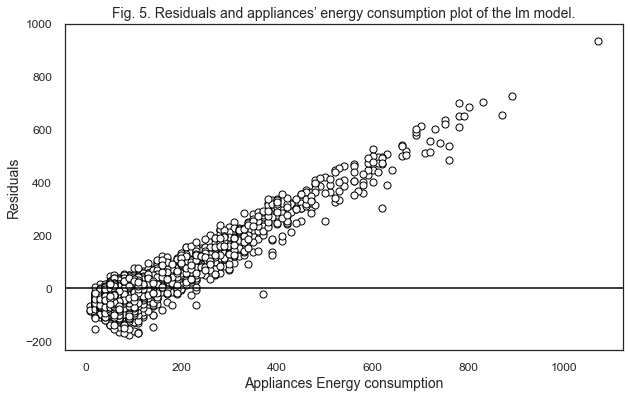

In [34]:
sns.set(style='white', font_scale=1)
fig, axs = plt.subplots(figsize = (10, 6))
sns.scatterplot(y_test, residuals,  edgecolor='black', color = 'white', s=50, linewidth=1)
axs.tick_params(axis='both', labelsize=14)
axs.axhline(y=0, color='black') # create line y=0 
plt.xlabel(xlabel='Appliances Energy consumption', fontsize = 14)
plt.ylabel(ylabel='Residuals', fontsize = 14)
plt.title('Fig. 5. Residuals and appliances’ energy consumption plot of the lm model.', fontsize = 14)
plt.yticks(np.arange(-200, 1200, 200), fontsize= 12)
plt.xticks(np.arange(0, 1200, 200), fontsize= 12)

plt.show()

Fig. 5 shows a residual plot for the linear regression model. The residuals were computed as the difference between the realvalues and the predicted values

From Fig. 5, it is obvious that therelationship between the variables and the energy consumption of appliances is not well represented by the linear model since the residuals are not normally distributed around the horizontal axis. In order to compare the performance of each of the regressionmodels, different performance evaluation indices are used here: 
- The root mean squared error (RMSE), 
- The coefficient of determina-tion or R-squared/R2, 
- The mean absolute error (MAE) 
- The meanabsolute percentage error (MAPE):

__Train data__
- RMSE on test set:  92.85
- R2-score on test set:  0.16
- MAE on test set:  51.65
- MAPE% on test set:  59.58

__Test data__   <<<<< still need to fix all value
- RMSE on test set:  92.85
- R2-score on test set:  0.16
- MAE on test set:  51.65
- MAPE% on test set:  59.58

### Feature Selection

__Feature Importance:__


Fig. RMSE using the RFE algorithm. The optimal number of predictors (34) is shown with the filled dot.

#### Recursive feature elimination with cross-validation

In [35]:
X = X_test.copy()
y = y_test.copy()

In [36]:
X.shape

(4932, 34)

In [37]:
y.shape

(4932,)

In [38]:
# Create the RFE object and compute a cross-validated score.
#model = LinearSVC(random_state=0, tol=1e-5)
#start = time()
#rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='accuracy')
#rfecv.fit(X, y)
#print('Optimal number of features: {}'.format(rfecv.n_features_))
#print('Time: ', time() - start)

In [39]:
#model = SVC(kernel="linear")
#start = time()
#model.fit(X, y)
#print('Time: ', time() - start)

In [40]:
#model = LinearSVC(random_state=0, tol=1e-5)
#start = time()
#model.fit(X, y)
#print('Time: ', time() - start)

__Plot number of features VS. cross-validation scores__

In [41]:
#plt.figure(figsize=(16, 9))
#plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
#plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
#plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
#plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

#plt.show()